### Chuẩn bị và tiền xử lý dữ liệu

In [21]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

In [22]:
# Đọc dữ liệu từ tập
data = pd.read_excel('data.xlsx')
print(data.shape)
data.head()

(1000, 11)


,Tài khoản vãng lai (USD),Thời hạn vay (tháng),Lịch sử tín dụng,Mục đích vay,Tài khoản tiết kiệm (USD),Số năm kinh nghiệm,Giới tính,Tuổi,Tình trạng nhà ở,Nghề nghiệp,Hạng tín dụng của KH
0,Không có,6,Đang vay của NH khác,Mua tbi âm thanh/hình ảnh,Ít,1-3 năm,Nữ,18-35,Nhà sở hữu riêng,"Chuyên môn, hành chính",'Tốt'
1,0-120,24,Đang vay của NH khác,Kinh doanh,Không có,4-6 năm,Nam,18-35,Nhà sở hữu riêng,"Chuyên môn, hành chính",'Tốt'
2,>120,42,Không có,Kinh doanh,Ít,<1 năm,Nam,18-35,Nhà sở hữu riêng,"Chuyên môn, hành chính",'Tốt'
3,<0,18,Đúng hạn tới hiện tại,Mua tbi âm thanh/hình ảnh,Ít,1-3 năm,Nam,18-35,Nhà sở hữu riêng,"Chuyên môn, hành chính",'Xấu'
4,<0,6,Đang vay của NH khác,Mua xe mới,Cao,4-6 năm,Nữ,36-45,Nhà sở hữu riêng,"Phổ thông, lâu dài",'Tốt'


In [23]:
data = data.dropna()

target = data.columns[-1]
features = data.columns[:-1].tolist()

# phân chia tập train và test
X_train, X_test, y_train, y_test = train_test_split(
    data[features], data[target], test_size=0.2, random_state=42)

# mã hoá nhãn cho biến phân loại sử dụng Label Encoding cho mô hình Cây quyết định
X_train_dt, X_test_dt = X_train.copy(), X_test.copy()
for col in X_train.columns:
    if X_train_dt[col].dtype == 'object':
        le = LabelEncoder()
        X_train_dt[col] = le.fit_transform(X_train_dt[col])
        X_test_dt[col] = le.transform(X_test_dt[col])

# mã hoá nhãn cho biến mục tiêu
le_y = LabelEncoder()
y_train = pd.Series(le_y.fit_transform(y_train), index=y_train.index)
y_test = pd.Series(le_y.transform(y_test), index=y_test.index)

# chuẩn hoá và mã hoá one-hot cho mô hình SVM
num_cols = ['Thời hạn vay (tháng)']
cat_cols = [col for col in features if col not in num_cols]

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

X_train_svm = preprocessor.fit_transform(X_train)
X_test_svm = preprocessor.transform(X_test)

# xử lý dữ liệu mất cân bằng bằng SMOTE
smote = SMOTE(random_state=42)
X_train_svm, y_train_svm = smote.fit_resample(X_train_svm, y_train)
X_train_dt, y_train_dt = smote.fit_resample(X_train_dt, y_train)

### Bước 1: Xây dựng mô hình

In [24]:
# Xây dựng mô hình Cây quyết định
dt_model = DecisionTreeClassifier(max_depth=3, random_state=42)
dt_model.fit(X_train_dt, y_train_dt)

,criterion,'gini'
,splitter,'best'
,max_depth,3
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [25]:
# Xây dựng mô hình SVM với grid search
svm_model = SVC()
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'degree': [2, 3, 4]  # chỉ cho 'poly' kernel
}

# thực hiện grid search với 5-fold cross validation
grid_search = GridSearchCV(estimator=svm_model,param_grid=param_grid,cv=5)
grid_search.fit(X_train_svm, y_train_svm)

# lấy tham số tối ưu từ grid search
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print("Tham số tốt nhất từ Grid Search:", best_params)
print("Điểm số tốt nhất từ Grid Search:", best_score)

# lấy mô hình tốt nhất từ grid search
best_svm = SVC(**best_params, probability=True)
best_svm.fit(X_train_svm, y_train_svm)

Tham số tốt nhất từ Grid Search: {'C': 10, 'degree': 4, 'kernel': 'poly'}
Điểm số tốt nhất từ Grid Search: 0.8383928571428572


,C,10
,kernel,'poly'
,degree,4
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,True
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


#### Bước 2a: Đánh giá mô hình

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_15688\2054037801.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df = pd.concat([metrics_df, pd.DataFrame([{


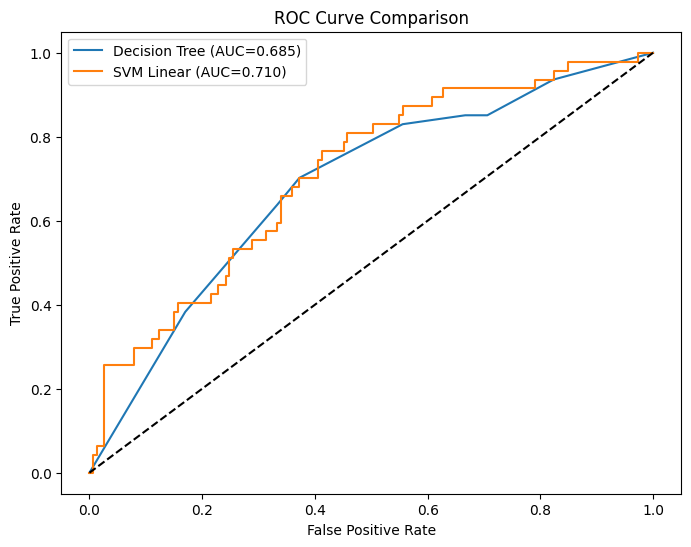

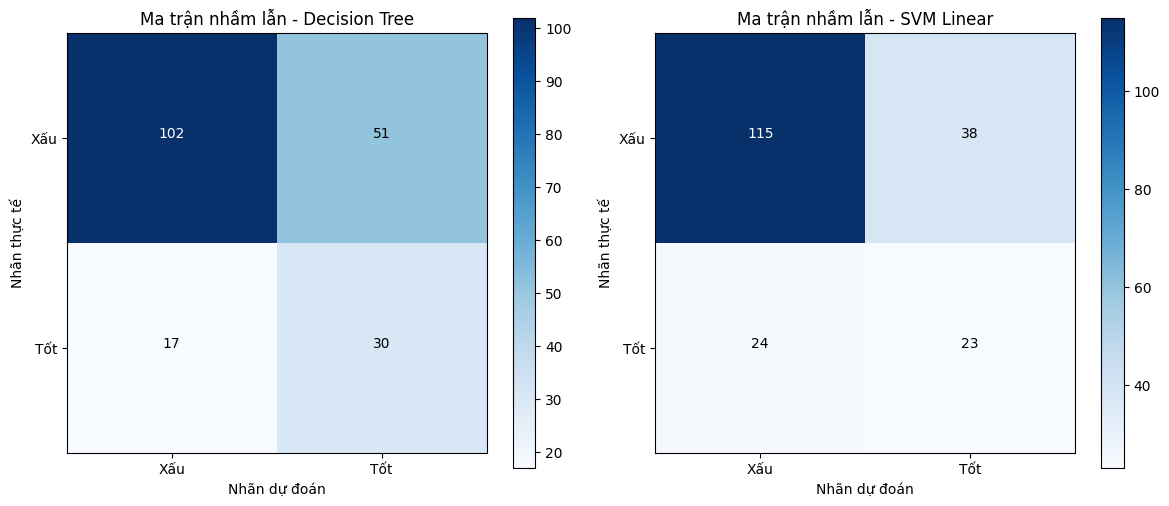

,Model,Accuracy,F1,Precision,Recall,ROC_AUC
0,Decision Tree,0.66,0.683906,0.742751,0.66,0.685162
1,SVM Linear,0.69,0.702661,0.721520,0.69,0.709637


In [26]:
# Danh sách mô hình và tập test tương ứng
models = {
    'Decision Tree': (dt_model, X_test_dt),
    'SVM Linear': (best_svm, X_test_svm)
}

# Lưu kết quả
metrics_df = pd.DataFrame(columns=['Model', 'Accuracy', 'F1', 'Precision', 'Recall', 'ROC_AUC'])

plt.figure(figsize=(8,6))

for name, (model, X_test_model) in models.items():
    y_pred = model.predict(X_test_model)
    
    # Classification report
    report = classification_report(y_test, y_pred, output_dict=True)
    metrics_df = pd.concat([metrics_df, pd.DataFrame([{
        'Model': name,
        'Accuracy': report['accuracy'],
        'F1': report['weighted avg']['f1-score'],
        'Precision': report['weighted avg']['precision'],
        'Recall': report['weighted avg']['recall'],
        'ROC_AUC': roc_auc_score(y_test, model.predict_proba(X_test_model)[:, 1]) if hasattr(model, "predict_proba") else np.nan
    }])], ignore_index=True)
    
    # ROC Curve
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test_model)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        auc = roc_auc_score(y_test, y_prob)
        plt.plot(fpr, tpr, label=f'{name} (AUC={auc:.3f})')

plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()

# so sánh ma trận nhầm lẫn
plt.figure(figsize=(12, 5))
for i, (name, (model, X_test_model)) in enumerate(models.items()):
    y_pred = model.predict(X_test_model)
    cm = confusion_matrix(y_test, y_pred)
    
    plt.subplot(1, 2, i+1)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'Ma trận nhầm lẫn - {name}')
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ["Xấu", "Tốt"])
    plt.yticks(tick_marks, ["Xấu", "Tốt"])
    plt.xlabel('Nhãn dự đoán')
    plt.ylabel('Nhãn thực tế')
    thresh = cm.max() / 2
    for r in range(cm.shape[0]):
        for c in range(cm.shape[1]):
            plt.text(c, r, format(cm[r, c], 'd'),
                     horizontalalignment="center",
                     color="white" if cm[r, c] > thresh else "black")
plt.tight_layout()
plt.show()

# In bảng kết quả
metrics_df

#### Bước 2b: Sử dụng mô hình

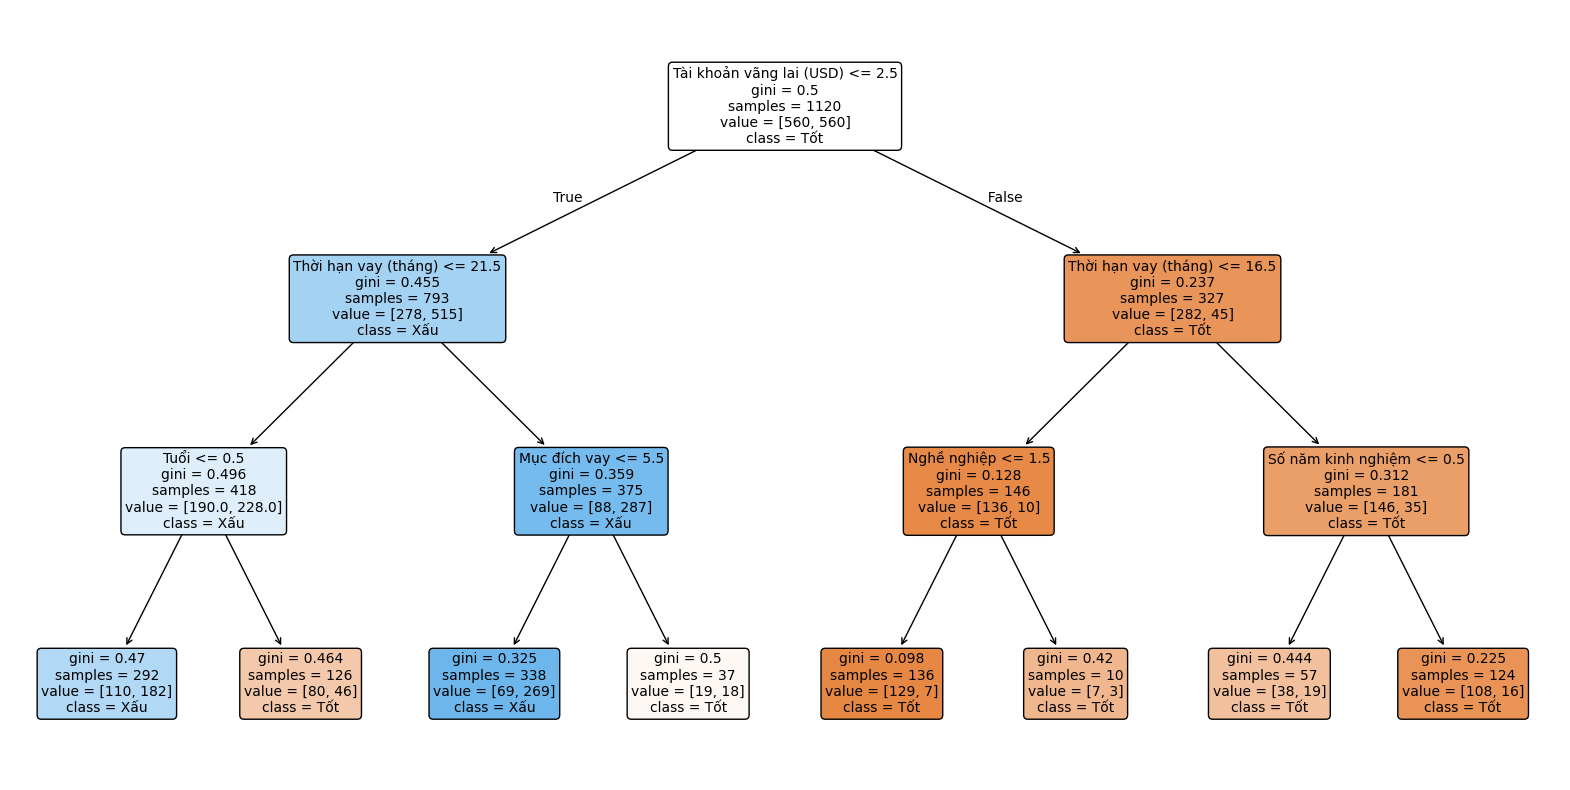

In [27]:
# Trực quan hóa cây quyết định

plt.figure(figsize=(20, 10))
plot_tree(
    dt_model,
    feature_names=features,
    class_names=["Tốt", "Xấu"],
    filled=True,
    rounded=True,
    fontsize=10
)
plt.show()

In [28]:
# Dự đoán dữ liệu mới với cả hai mô hình
new_data = pd.DataFrame([['0-120',12,'Đang vay của NH khác','Mua xe mới','Không có','<1 năm','Nam','18-35','Nhà sở hữu riêng','Phổ thông, lâu dài']], columns=features)

new_data_dt = new_data.copy()
for col in new_data_dt.columns:
    if new_data_dt[col].dtype == 'object':
        le = LabelEncoder()
        le.fit(data[col])
        new_data_dt[col] = le.transform(new_data_dt[col])

prediction = dt_model.predict(new_data_dt)
if prediction[0] == 1:
    print("Dự đoán bằng Cây quyết định: Tốt")
else:
    print("Dự đoán bằng Cây quyết định: Xấu")

new_data_svm = preprocessor.transform(new_data)
prediction = best_svm.predict(new_data_svm)

if prediction[0] == 1:
    print("Dự đoán bằng SVM: Tốt")
else:
    print("Dự đoán bằng SVM: Xấu")

Dự đoán bằng Cây quyết định: Tốt
Dự đoán bằng SVM: Xấu
